In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import CubicSpline
from scipy.interpolate import RegularGridInterpolator

In [11]:
class IsingModel:
    def __init__(self, L, T):
        #parametros do modelo
        self.L = L
        self.T = T

        #array com os spins
        self.spins = np.ones((L,L))

        #arrays para guardar evoluções das variáveis
        self.energies= [self.calc_ener_total()]
        self.magnetizations= [L**2]

        #energia e magnetização total
        self.energy_total = self.calc_ener_total()
        self.magnet_total = np.sum(self.spins)

    def calc_ener_spin(self, i, j):
        #calcular a energia de um spin
        spin= self.spins[i,j]
        neighbours= (
        self.spins[(i+1)%self.L, j] + 
        self.spins[i, (j+1)%self.L] + 
        self.spins[(i-1)%self.L, j] + 
        self.spins[i, (j-1)%self.L]
        )
        energy=-spin*neighbours
        return energy
    
    def calc_ener_total( self ):
        energy=0
        for i in range(self.L):
            for j in range(self.L):
                energy+= -self.spins[i,j]*(self.spins[(i+1)%self.L,j]+ self.spins[i,(j+1)%self.L])
        return energy
    
    def calc_ener ( self ):
        energy=self.energy_total/self.L**2
        return energy
    
    def calc_mag( self ):
        mag = self.magnet_total
        return mag
    

    def iter_monte_carlo(self,n_iter):

        #calcular a energia do sistema inicialmente
        E = self.energies[0]
        Mag = self.magnetizations[0]

        #iterar com o método de Metropolis Hastings
        for _ in tqdm(range(n_iter), desc=f"L={self.L:6d},T={self.T:8f}"):
            #proposta: spin flip
            i = np.random.randint(0, self.L)
            j = np.random.randint(0, self.L)
            prop = self.spins.copy()
            prop[i, j] *= -1

            #calcular a probabilidade de a proposta ser aceite
            Delta_E = -2*self.calc_ener_spin(i, j)
            Delta_Mag = -2*self.spins[i,j]
            R = np.exp(-Delta_E/(self.T))
            
            u = np.random.uniform(0, 1)
            if R > u:
                self.spins = prop
                E += Delta_E
                Mag += Delta_Mag
                self.energy_total = E
                self.magnet_total = Mag

            self.energies.append(E)
            self.magnetizations.append(Mag)
    
    @property
    def energy(self):
        return np.array(self.energies)
    


## 1. Tempo de Termalização

**a)** Para cada combinação de L e T, corremos a simulação iter_monte_carlo, obtendo uma lista de como variou a energia a cada passo da iteração (ising.energies). A n-ésima entrada dessa lista (ising.energies[n-1]) dá a energia total do sistema após n iterações, pelo que a energia média, e, em função de n é ising.energies[n-1]/L^2.

L=   128,T=4.000000: 100%|██████████| 10000/10000 [00:00<00:00, 38319.02it/s]


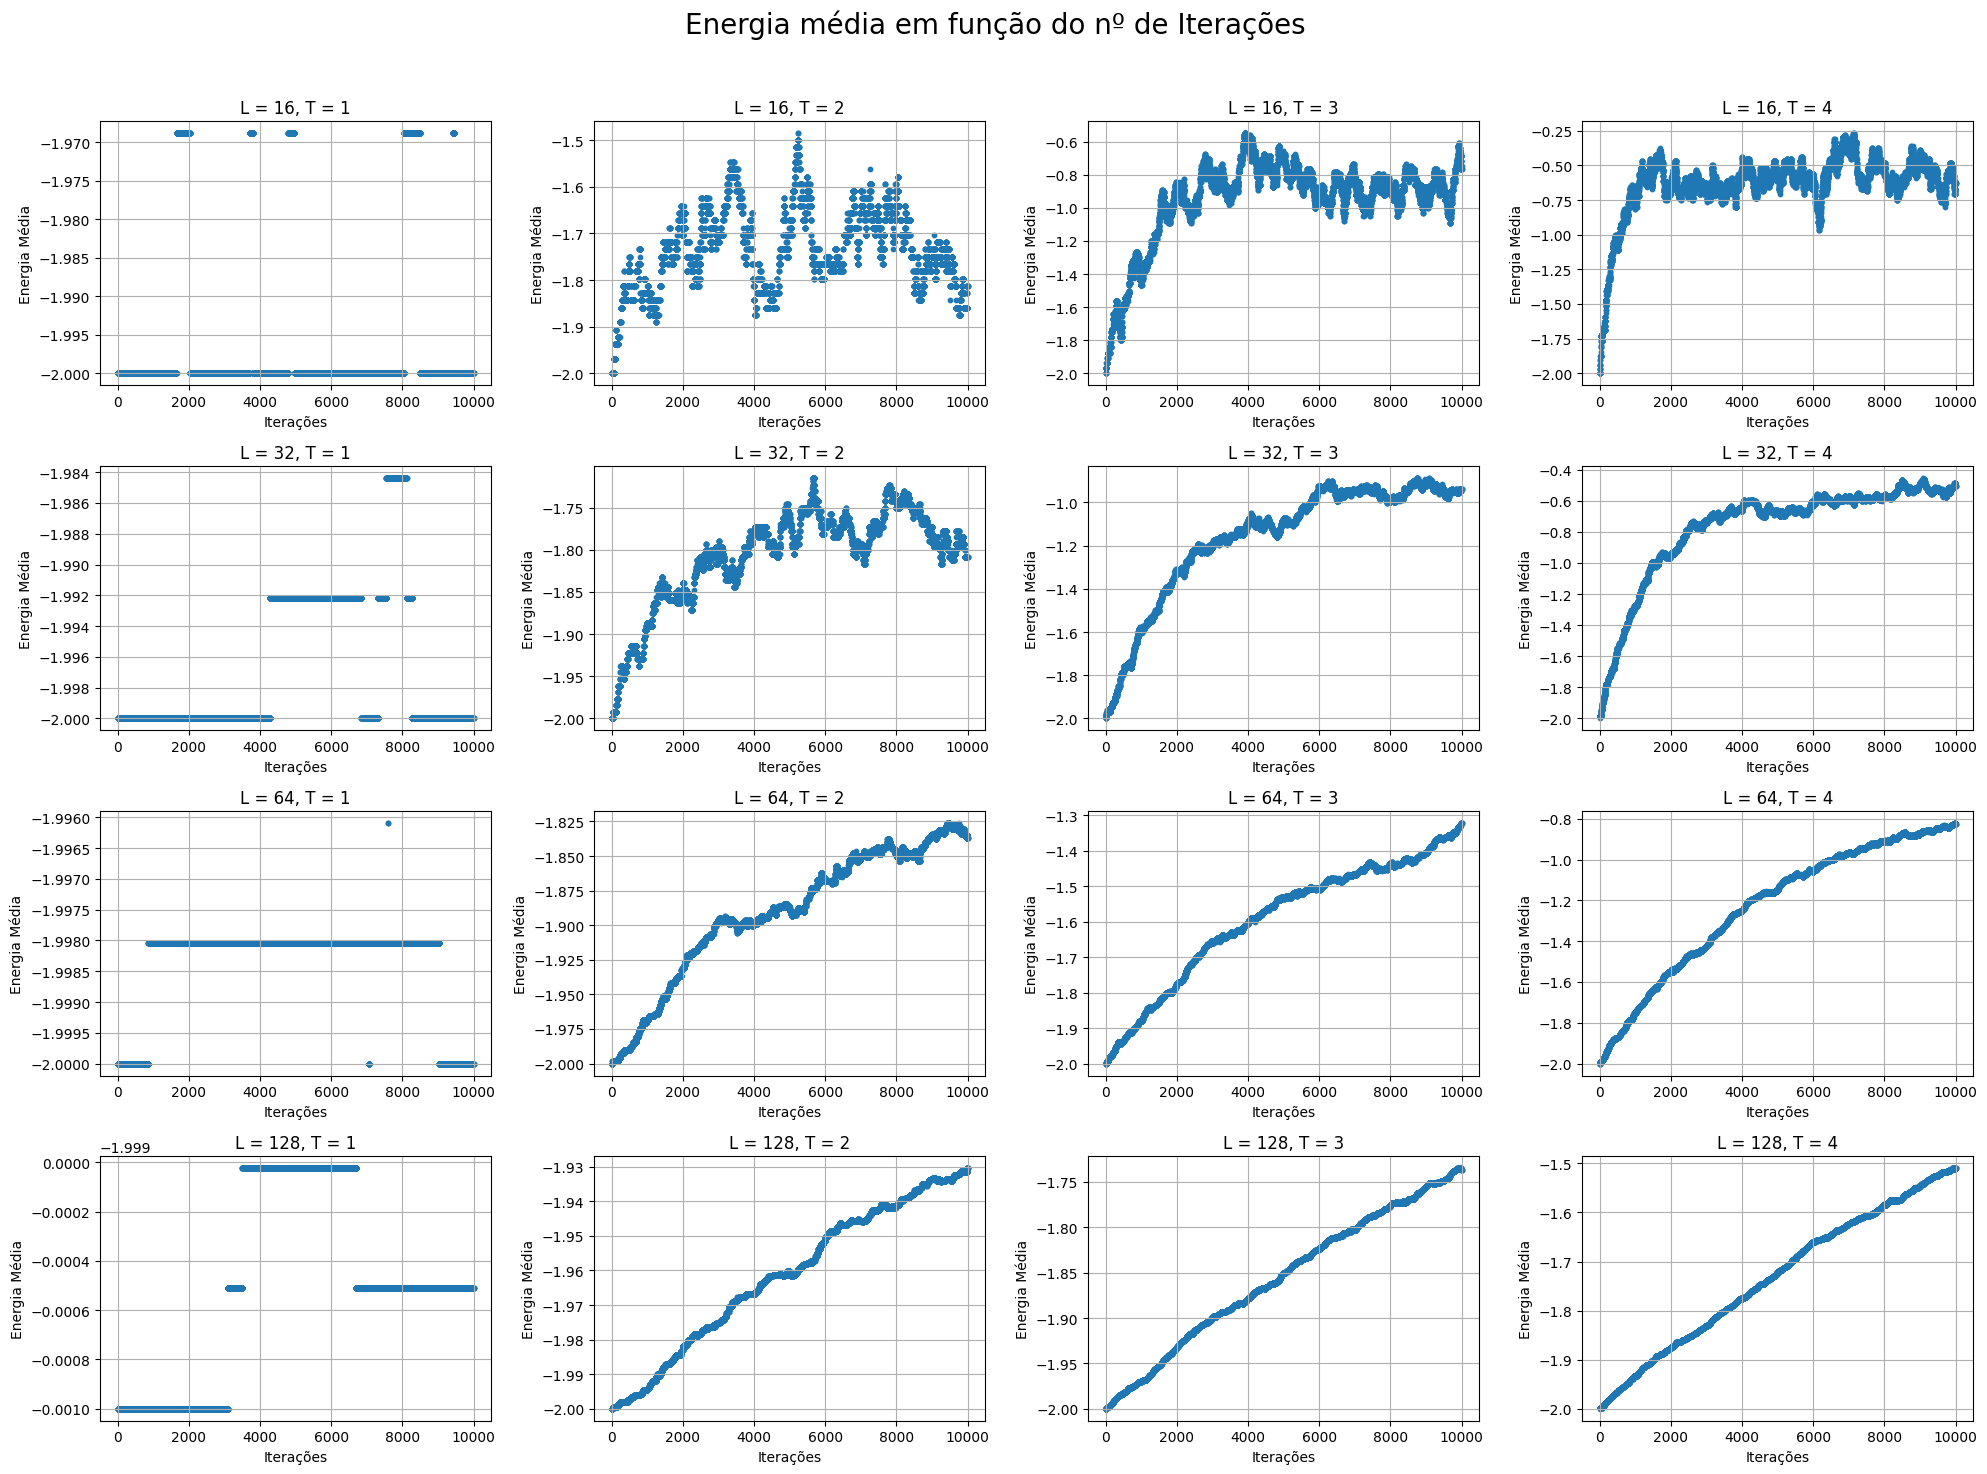

In [12]:
L_array = [16, 32, 64, 128]
T_array = [1, 2, 3, 4]
N = 10000 #limite superior para o número de iterações

fig, axes = plt.subplots(len(L_array), len(T_array), figsize=(20, 15))
fig.suptitle('Energia média em função do nº de Iterações', fontsize=20)

for i, L in enumerate(L_array):
    for j, T in enumerate(T_array):
        
        ising = IsingModel(L, T)
        ising.iter_monte_carlo(N)
        avg_ener = np.array(ising.energies[1:])/(L*L)

        ax = axes[i, j]
        ax.scatter(np.arange(1, N + 1), avg_ener, s=10)
        ax.set_title(f'L = {L}, T = {T}')
        ax.set_xlabel('Iterações')
        ax.set_ylabel('Energia Média')
        ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajusta o layout para dar espaço ao título
plt.show()

**b)** Com o módulo scipy.optimize, ajustámos aos dados anteriores uma função como a descrita no enunciado, determinando os parâmetros ef e tau, que são depois guardados no dicionário fit_results.

In [13]:
def ener_func(N, ef, tau):
    return ef + (e0 - ef) * np.exp(-N / tau)

def guesses_for_ef_and_tau(energy_vals, n_points):
    #o guess para ef será a média dos últimos 10% de valores
    ef_guess = np.mean(avg_ener[-int(0.1 * len(avg_ener)):])
    #o guess para tau será resultante de inverter a equação, usando ef_guess
    e0 = energy_vals[0]
    if e0 - ef_guess <= 0:
        return [ef_guess, len(energy_vals) / 10]
    
    indices = np.random.choice(np.arange(1, len(energy_vals)), size=n_points, replace=False)
    taus = [-i / np.log((energy_vals[i]-ef_guess) / (e0-ef_guess)) for i in indices 
            if energy_vals[i] > ef_guess and np.isfinite((energy_vals[i] - ef_guess) / (e0 - ef_guess))]
    
    tau_guess = np.mean(taus) if taus else len(energy_vals) / 10
    return [ef_guess, tau_guess]

# Dicionário para guardar os parâmetros de ajuste
fit_results = {}

for i, L in enumerate(L_array):
    for j, T in enumerate(T_array):
        
        ising = IsingModel(L, T)
        ising.iter_monte_carlo(N)
        N_values = np.arange(0, N + 1)
        avg_ener = np.array(ising.energies) / (L * L)
        e0 = avg_ener[0]

        # Chamada do ajuste com estimativas iniciais
        parameters, _ = curve_fit(ener_func, N_values, avg_ener, p0=guesses_for_ef_and_tau(avg_ener, 10))
        ef, tau = parameters

        # A chave (L,T) estará associada a um dicionário onde se guardam os valores ef e tau
        fit_results[(L, T)] = {'ef': ef, 'tau': tau}

print("Resultados do ajuste (ef e tau):\n")
for (L, T), params in fit_results.items():
    ef = params['ef']
    tau = params['tau']
    print(f"L = {L:3d}, T = {T:3d} --> ef = {ef:.5f}, tau = {tau:.2f}")

L=   128,T=4.000000: 100%|██████████| 10000/10000 [00:00<00:00, 39831.08it/s]

Resultados do ajuste (ef e tau):

L =  16, T =   1 --> ef = -1.99425, tau = 347.56
L =  16, T =   2 --> ef = -1.67019, tau = 3055.57
L =  16, T =   3 --> ef = -0.77356, tau = 729.80
L =  16, T =   4 --> ef = -0.55091, tau = 406.02
L =  32, T =   1 --> ef = -1.99748, tau = 462.43
L =  32, T =   2 --> ef = -1.70591, tau = 1642.24
L =  32, T =   3 --> ef = -0.98139, tau = 2778.03
L =  32, T =   4 --> ef = -0.57437, tau = 1396.67
L =  64, T =   1 --> ef = 51.29365, tau = 130551704.00
L =  64, T =   2 --> ef = -1.84905, tau = 3808.16
L =  64, T =   3 --> ef = -1.03586, tau = 7980.39
L =  64, T =   4 --> ef = -0.63214, tau = 5503.28
L = 128, T =   1 --> ef = 0.64554, tau = 16484555.66
L = 128, T =   2 --> ef = -1.73526, tau = 33774.93
L = 128, T =   3 --> ef = -1.51020, tau = 14453.10
L = 128, T =   4 --> ef = -1.00880, tau = 14626.18


**c)** 

## 2. Determinação da Temperatura Crítica

**a)** 

L=128: 100%|██████████| 15/15 [00:00<00:00, 32.47it/s]


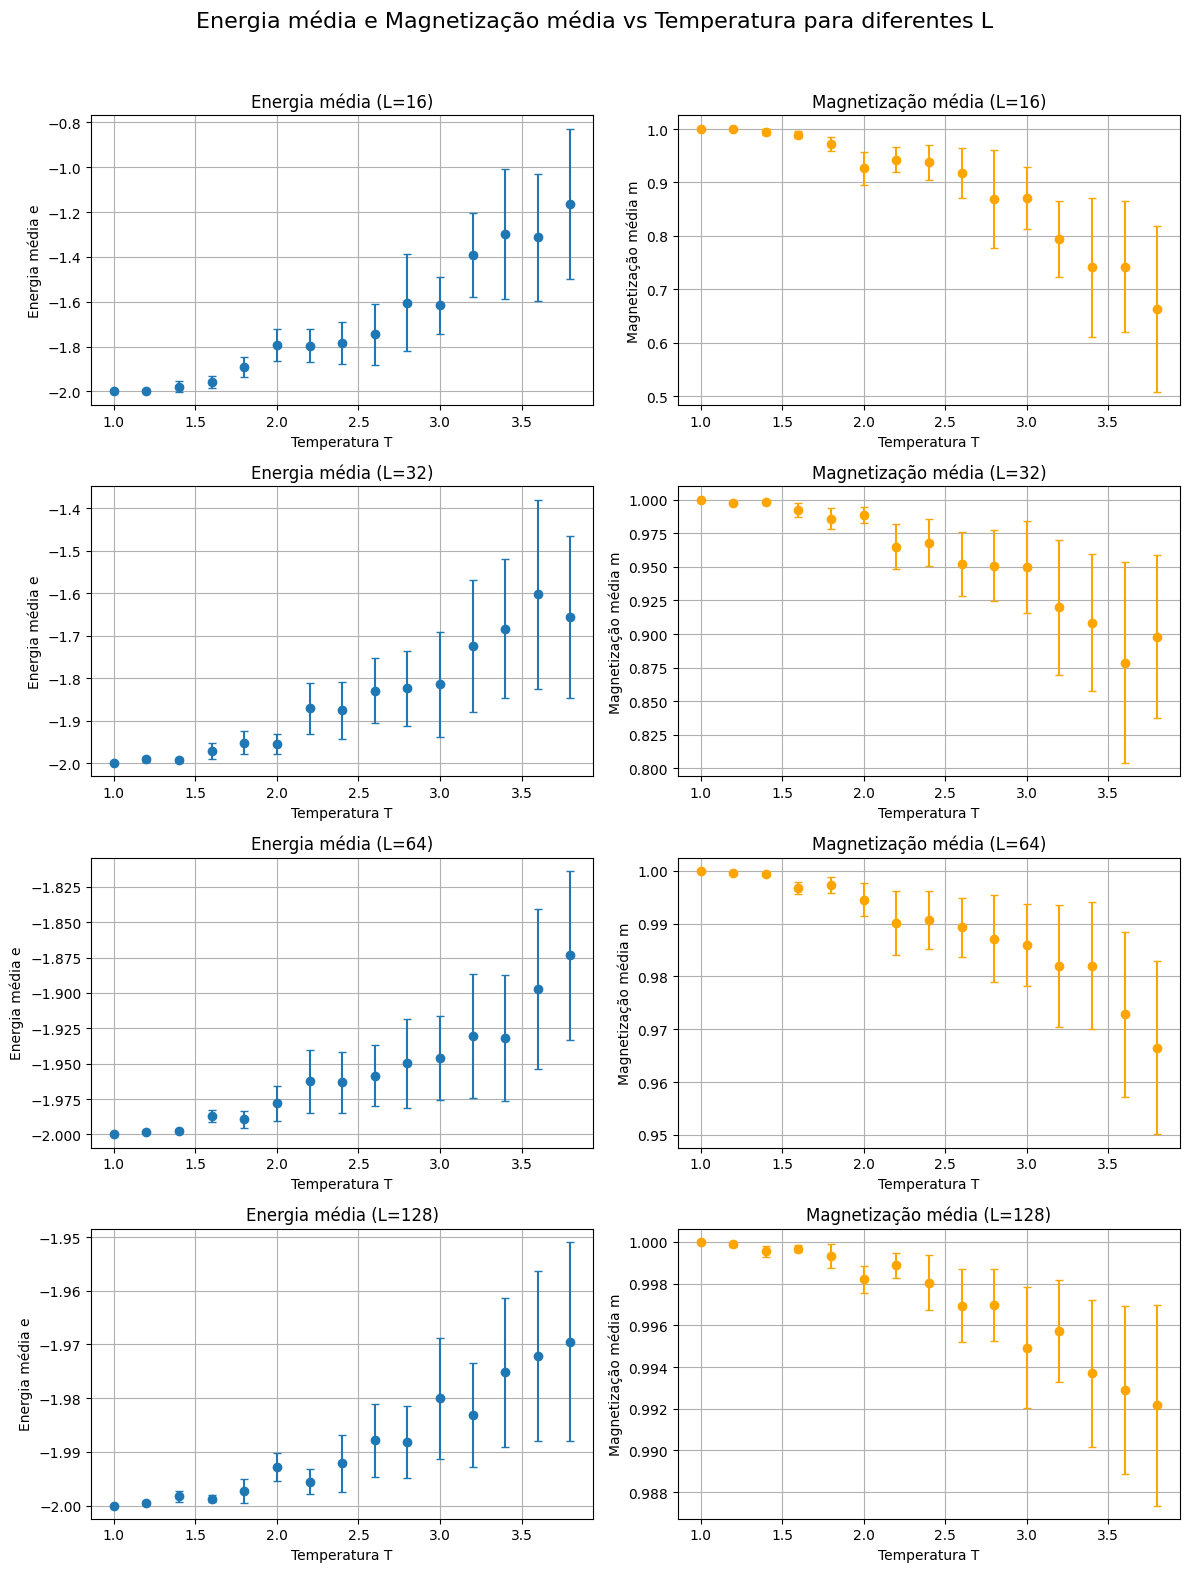

In [32]:
h = 0.2
T_values = np.arange(1, 4, h)
N_measurements = 1000

# Iremos armazenar os resultados no seguinte dicionário:
results = {L: {'T': [], 'e_mean': [], 'e_std': [], 'm_mean': [], 'm_std': []} for L in L_array}

fig, axes = plt.subplots(4, 2, figsize=(12, 16))
fig.suptitle('Energia média e Magnetização média vs Temperatura para diferentes L', fontsize=16)

for i, L in enumerate(L_array):
    for T in tqdm(T_values, desc=f"L={L}"):
        ising = IsingModel(L, T)
        ising.iter_monte_carlo(N_measurements)
        
        energies = np.array(ising.energies)/(L*L)
        magnetizations = np.array(ising.magnetizations)/(L*L)
        
        e_mean = np.mean(energies)
        e_std = np.std(energies)
        m_mean = np.mean(magnetizations)
        m_std = np.std(magnetizations)
        
        results[L]['T'].append(T)
        results[L]['e_mean'].append(e_mean)
        results[L]['e_std'].append(e_std)
        results[L]['m_mean'].append(m_mean)
        results[L]['m_std'].append(m_std)

    #Para realizar o plot
    ax_e = axes[i, 0]
    ax_e.errorbar(T_values, results[L]['e_mean'], yerr=results[L]['e_std'], fmt='o', capsize=3, label=f'L={L}')
    ax_e.set_xlabel('Temperatura T')
    ax_e.set_ylabel('Energia média e')
    ax_e.set_title(f'Energia média (L={L})')
    ax_e.grid(True)
    ax_m = axes[i, 1]
    ax_m.errorbar(T_values, results[L]['m_mean'], yerr=results[L]['m_std'], fmt='o', capsize=3, color='orange', label=f'L={L}')
    ax_m.set_xlabel('Temperatura T')
    ax_m.set_ylabel('Magnetização média m')
    ax_m.set_title(f'Magnetização média (L={L})')
    ax_m.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**b)**

L = 16: Tc = 3.2
L = 32: Tc = 3.2
L = 64: Tc = 3.6
L = 128: Tc = 3.4


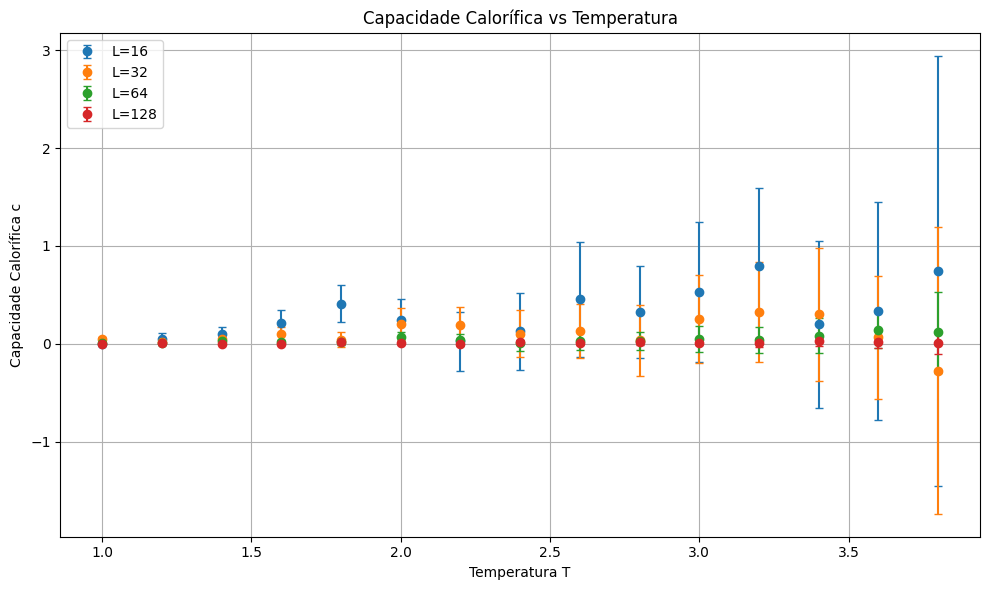

In [38]:
heat_capacities = {L: {'T': [], 'c': [], 'c_err': []} for L in L_array}

def discrete_derivative_for_data(T, Y, Y_err):
    if len(T) != len(Y):
        raise ValueError("T and Y must have the same length")
    dY_values = [(Y[1]-Y[0])/(T[1]-T[0])]
    Err_values = [np.sqrt(Y_err[0]*Y_err[0] + Y_err[1]*Y_err[1])/(T[1]-T[0])]
    for i in range(1, len(T)-1):
        dY_values.append((Y[i+1]-Y[i-1])/(T[i+1]-T[i-1]))
        Err_values.append(np.sqrt(Y_err[i-1]*Y_err[i-1] + Y_err[i+1]*Y_err[i+1])/(T[i+1]-T[i-1]))
    dY_values.append((Y[-1]-Y[-2])/(T[-1]-T[-2]))
    Err_values.append(np.sqrt(Y_err[-1]*Y_err[-1] + Y_err[-2]*Y_err[-2])/(T[-1]-T[-2]))
    return dY_values, Err_values

for L in L_array:
    c_values, c_error = discrete_derivative_for_data(results[L]['T'], results[L]['e_mean'], results[L]['e_std'])
    heat_capacities[L]['T'] = results[L]['T']
    heat_capacities[L]['c'] = c_values
    heat_capacities[L]['c_err'] = c_error
    idx_max = np.argmax(heat_capacities[L]['c'])
    Tc = heat_capacities[L]['T'][idx_max]
    print(f"L = {L}: Tc = {Tc:.1f}")


# Plot da capacidade calorífica em função de T, com barras de erro

plt.figure(figsize=(10, 6))

for L in L_array:
    plt.errorbar(heat_capacities[L]['T'], heat_capacities[L]['c'], yerr=heat_capacities[L]['c_err'], fmt='o', capsize=3, label=f'L={L}')

plt.xlabel('Temperatura T')
plt.ylabel('Capacidade Calorífica c')
plt.title('Capacidade Calorífica vs Temperatura')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 3. Determinação da Energia Livre de Helmholtz, F